On rajoute les données meteo

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import cm
from matplotlib.colors import ListedColormap

from sklearn.preprocessing import SplineTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import GammaRegressor

from statsmodels.tsa.api import VAR

In [2]:
def fct_scores_mse(Y_true, Y_pred, liste_stations):
    
    Y_true = Y_true.sort_values(by = ["Date"])
    Y_pred = Y_pred.sort_values(by = ["Date"])
    
    liste_mse = []
    for code in liste_stations:
        liste_mse.append(np.mean(np.square(Y_true[code].values - Y_pred[code].values)))
    resultat = pd.DataFrame({"Code station": liste_stations, "MSE": liste_mse})
    return resultat

In [3]:
stations_debit = pd.read_csv("../Data/Base/Stations_Debit.csv")
liste_stations_debit = list(stations_debit["Code station"])

mesures_train_X = pd.read_csv("../Data/Base_journalier/Mesures_Train_X.csv")
mesures_train_X["Date"] = pd.to_datetime(mesures_train_X["Date"], format = "%Y/%m/%d %H:%M:%S")
mesures_train_Y = pd.read_csv("../Data/Base_journalier/Mesures_Train_Y.csv")
mesures_train_Y["Date"] = pd.to_datetime(mesures_train_Y["Date"], format = "%Y/%m/%d %H:%M:%S")

train_split_X = pd.read_csv("../Data/Base_journalier/Index_CV_X.csv")
train_split_Y = pd.read_csv("../Data/Base_journalier/Index_CV_Y.csv")

mesures_test_X = pd.read_csv("../Data/Base_journalier/Mesures_Test_X.csv")
mesures_test_X["Date"] = pd.to_datetime(mesures_test_X["Date"], format = "%Y/%m/%d %H:%M:%S")
mesures_test_Y = pd.read_csv("../Data/Base_journalier/Mesures_Test_Y.csv")
mesures_test_Y["Date"] = pd.to_datetime(mesures_test_Y["Date"], format = "%Y/%m/%d %H:%M:%S")

In [4]:
stations_meteo = pd.read_csv("../Data/Base/Stations_Meteo.csv")
liste_stations_meteo = list(stations_meteo["ID"].apply(lambda x: str(x).rjust(5, "0")))
colonnes_meteo = ["Pression", "Vent_Nord", "Vent_Est", "Vitesse_vent", "Temperature", "Humidite", "Precipitations"]
tempo = []
for code in liste_stations_meteo:
    tempo += [tp + "_" + code for tp in colonnes_meteo]
colonnes_meteo_stations = tempo

In [5]:
def fct_Modele_SplineGamma_fit(mesures_train, liste_stations, n_knots):
    ## Fonction pour déterminer les splines cycliques, GAM gamma
    # mesures: dataframe X d'entrainement
    # n_knots: le nombre de noeuds
    
    mesures_stations = mesures_train[["Date"] + liste_stations]
    # On prend en abscisse le delta de temps par rapport au 01/01 de l'année en cours
    mesures_tofit = pd.DataFrame()
    liste_annee = np.unique(mesures_stations["Date"].apply(lambda x: x.year))
    for curr_annee in liste_annee:
        mesures_annee = mesures_stations[mesures_stations["Date"].apply(lambda x: x.year == curr_annee)]
        n_mesures = len(mesures_annee)
        mesures_annee.index = range(n_mesures)
        jour_an = pd.to_datetime(str(curr_annee)+"/01/01")
        jours_delta = (mesures_annee["Date"] - jour_an).apply(lambda x: x.delta)
        jours_delta.index = range(n_mesures)
        mesures_annee = pd.concat([mesures_annee, pd.DataFrame({"Delta": jours_delta})], axis = 1)
        mesures_tofit = pd.concat([mesures_tofit, mesures_annee])
    
    resultat = pd.DataFrame({"Delta": np.unique(mesures_tofit["Delta"])})
    # Calcul de la spline
    for code in liste_stations:
        X = mesures_tofit[["Delta", code]]
        spline = SplineTransformer(n_knots=n_knots,
                                   extrapolation="periodic")
        model = make_pipeline(spline, GammaRegressor(alpha = 0))
        model.fit(X[["Delta"]], X[code])
        composante = model.predict(resultat[["Delta"]])
        composante = pd.DataFrame(composante, columns = [code])
        resultat = pd.concat([resultat, composante], axis = 1)
    return resultat

In [6]:
def fct_Modele_SplineGamma_predict(fit, liste_dates, liste_stations):
    
    fit["Delta_Jour"] = fit.index
    max_jours = np.max(fit["Delta_Jour"])
    
    # On retourne la bonne valeur
    resultat = pd.DataFrame({"Date": liste_dates})
    liste_annees = np.unique(liste_dates.apply(lambda x: x.year))
    predictions = []
    for curr_annee in liste_annees:
        dates_annee = pd.DataFrame({"Date": liste_dates[liste_dates.apply(lambda x: x.year == curr_annee)]})
        jour_an = pd.to_datetime(str(curr_annee)+"/01/01")
        dates_annee["Delta_Jour"] = (dates_annee - jour_an)
        dates_annee["Delta_Jour"] = dates_annee["Delta_Jour"].apply(lambda x: x.days)
        for index, row in dates_annee.iterrows():
            predictions.append(fit[fit["Delta_Jour"] == row["Delta_Jour"]%(max_jours+1)][liste_stations].iloc[0,:])
    resultat[liste_stations] = predictions
    return resultat

In [7]:
def fct_ModeleSplineGamme_residus(fit, mesures, liste_stations):
    
    liste_dates = mesures["Date"]
    predictions = fct_Modele_SplineGamma_predict(fit, liste_dates, liste_stations)
    
    resultat = pd.DataFrame({"Date": liste_dates})
    for code in liste_stations:
        residus = mesures[code] - predictions[code]
        resultat[code] = residus
    return resultat

# AIC BIC

In [97]:
n_knots = 10

aic_scores = []
bic_scores = []
for curr_p in tqdm(range(1, 16)):
    spline_fit = fct_Modele_SplineGamma_fit(mesures_train_X, liste_stations_debit, n_knots)
    mesures_train_X_residus = fct_ModeleSplineGamme_residus(spline_fit, mesures_train_X, liste_stations_debit)
    
    # Ajouts des variables exogenes
    var_exo = pd.DataFrame()
    #ajout du passé
    for i in range(8):
        mesures_meteo = mesures_train_X[colonnes_meteo_stations].shift(i)
        mesures_meteo.columns = [col+"_m"+str(i) for col in colonnes_meteo_stations]
        var_exo = pd.concat([var_exo, mesures_meteo], axis = 1)
    #ajout des prédictions meteo
    for i in range(1, 9):
        mesures_meteo = mesures_train_X[colonnes_meteo_stations].shift(-i)
        mesures_meteo.columns = [col+"_p"+str(i) for col in colonnes_meteo_stations]
        var_exo = pd.concat([var_exo, mesures_meteo], axis = 1)
        
    var_exo = var_exo.interpolate(limit_direction="both")
    model_VAR = VAR(mesures_train_X_residus[liste_stations_debit], var_exo)
    fit_VAR = model_VAR.fit(curr_p)
    
    aic_scores.append(fit_VAR.aic)
    bic_scores.append(fit_VAR.bic)

100%|██████████| 15/15 [06:10<00:00, 24.71s/it]


In [98]:
scores = pd.DataFrame({"Lag": range(1, 16), "AIC": aic_scores, "BIC": bic_scores})
scores

,Lag,AIC,BIC
0,1,-1075.415456,-896.121648
1,2,-1097.056944,-916.573202
2,3,-1091.932682,-910.258456
3,4,-1090.179135,-907.313877
4,5,-1094.286783,-910.229943
5,6,-1102.854986,-917.606015
6,7,-1100.498049,-914.056396
7,8,-1089.858807,-902.223922
8,9,-1087.854101,-899.025433
9,10,-1092.276272,-902.253269


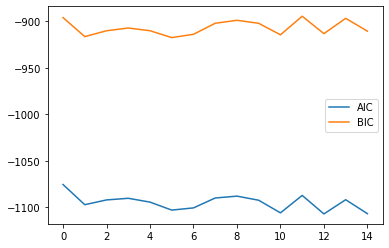

In [100]:
plt.plot(scores["AIC"], label = "AIC")
plt.plot(scores["BIC"], label = "BIC")
plt.legend()

In [101]:
scores.to_csv("../Data/VAR_Meteo/scores.csv",
              index=False)

# Val croisée

In [102]:
n_knots = 10

for curr_p in tqdm(range(1,8)):
    cv_scores = pd.DataFrame({"Code station": liste_stations_debit})
    
    for curr_split in range(9):
        
        # Entraintement
        curr_train_X = mesures_train_X[train_split_X["Train_" + str(curr_split)]]
        curr_train_Y = mesures_train_Y[train_split_Y["Train_" + str(curr_split)]]

        spline_fit = fct_Modele_SplineGamma_fit(curr_train_X, liste_stations_debit, n_knots)
        mesures_train_X_residus = fct_ModeleSplineGamme_residus(spline_fit, curr_train_X, liste_stations_debit)
        
         # Ajouts des variables exogenes
        var_exo = pd.DataFrame()
        #ajout du passé
        for i in range(8):
            mesures_meteo = curr_train_X[colonnes_meteo_stations].shift(i)
            mesures_meteo.columns = [col+"_m"+str(i) for col in colonnes_meteo_stations]
            var_exo = pd.concat([var_exo, mesures_meteo], axis = 1)
        #ajout des prédictions meteo
        for i in range(1, 9):
            mesures_meteo = curr_train_X[colonnes_meteo_stations].shift(-i)
            mesures_meteo.columns = [col+"_p"+str(i) for col in colonnes_meteo_stations]
            var_exo = pd.concat([var_exo, mesures_meteo], axis = 1)
        var_exo = var_exo.interpolate(limit_direction="both")
        
        model_VAR = VAR(mesures_train_X_residus[liste_stations_debit], var_exo)
        fit_VAR = model_VAR.fit(curr_p)

        # Prédictions
        curr_test_X = mesures_train_X[train_split_X["Test_" + str(curr_split)]]
        curr_test_X_residus = fct_ModeleSplineGamme_residus(spline_fit, curr_test_X, liste_stations_debit)
        curr_test_Y = mesures_train_Y[train_split_Y["Test_" + str(curr_split)]]
        liste_dates = curr_test_Y["Date"]
        predictions_Y = fct_ModeleARMeteo_predict(curr_test_X, fit_VAR, curr_p, liste_dates, liste_stations_debit,
                                            spline_fit)
        
        # Score
        curr_scores = fct_scores_mse(curr_test_Y, predictions_Y, liste_stations_debit)
        cv_scores["Split_" + str(curr_split)] = curr_scores["MSE"]

    cv_moyen = []
    for code in liste_stations:
        score = np.mean(cv_scores[cv_scores["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
        cv_moyen.append(score)    
    cv_scores["Moyenne"] = cv_moyen
    cv_scores.to_csv("../Data/VAR_Meteo/cv_p_" + str(curr_p).rjust(2, "0") + ".csv",
                     index=False)  

  0%|          | 0/7 [00:01<?, ?it/s]


NameError: name 'fct_ModeleAR_predict' is not defined

In [94]:
mesures_train_X_residus

,Date,O0200020,O2620010,O6140010,O9000010,K0030020,K0100020,K0260020,K0550010,K0690010,...,H0100020,H0400010,H0400020,H0800011,H0800012,H0810010,H1700010,H3930020,H4340020,H8100021
0,2010-01-01,0.235029,1.225912,-17.224742,-169.964756,-0.343270,-2.085727,-2.743666,-8.824059,-46.417226,...,-4.853213,-15.212088,-25.809619,-21.337425,-13.391728,-31.841223,-70.939058,-116.160303,-138.057078,-76.071700
1,2010-01-02,-3.656171,-21.323873,76.017532,3.364838,-0.383821,-2.088426,-2.591381,-3.664842,-45.772031,...,-5.249156,-17.785423,-26.047414,-23.614986,-14.091005,-30.480291,-64.000975,-86.764548,-108.231238,-68.004412
2,2010-01-03,-6.205959,-23.400522,9.200900,24.671135,-0.402385,-2.498931,-4.472968,-11.154151,-45.552715,...,-7.448399,-21.922777,-26.034206,-25.220922,-14.498810,-31.155979,-61.920952,-123.548284,-122.968073,-19.777827
3,2010-01-04,-8.047037,-36.590639,-36.831025,-60.778846,-0.377235,-2.288612,-4.321675,-9.893959,-9.035302,...,-9.660894,-27.638119,-25.808765,-25.963058,-14.649187,-31.538169,-64.240143,-158.212116,-174.220370,-113.007251
4,2010-01-05,-4.912110,-21.105926,-27.650898,-55.134706,-0.356646,-2.168012,-4.530186,-7.686911,5.459333,...,-11.221802,-31.962846,-25.519859,-27.591359,-13.409537,-31.547009,-66.566748,-179.541473,-192.525905,-106.225455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3647,2019-12-27,39.631360,167.548986,600.780014,1067.337054,0.997364,3.330269,13.327009,22.901929,41.898537,...,6.847701,20.890878,21.954827,21.729179,4.204351,20.857436,28.441166,112.523887,131.747411,344.952937
3648,2019-12-28,33.239755,132.942351,492.290060,875.924205,0.944943,2.829755,12.592725,24.922190,44.224751,...,8.547113,32.538259,24.230080,26.774769,6.064760,24.724432,34.224391,127.273376,136.959759,373.150403
3649,2019-12-29,26.790804,110.648952,388.857343,718.460555,0.847784,2.070442,9.587806,18.441882,36.283187,...,9.488339,38.580533,31.290662,22.780068,4.799073,31.122325,37.315400,154.744707,166.342110,416.927651
3650,2019-12-30,21.683882,88.829060,317.968276,586.588994,0.744214,1.581408,7.771073,14.987203,34.656811,...,7.681974,39.175309,33.343879,25.701630,6.166178,32.888170,42.970187,164.872639,161.080769,421.295038


In [73]:
var_exo

,Pression_07005_m0,Vent_Nord_07005_m0,Vent_Est_07005_m0,Vitesse_vent_07005_m0,Temperature_07005_m0,Humidite_07005_m0,Precipitations_07005_m0,Pression_07015_m0,Vent_Nord_07015_m0,Vent_Est_07015_m0,...,Temperature_07747_m7,Humidite_07747_m7,Precipitations_07747_m7,Pression_07761_m7,Vent_Nord_07761_m7,Vent_Est_07761_m7,Vitesse_vent_07761_m7,Temperature_07761_m7,Humidite_07761_m7,Precipitations_07761_m7
0,99277.777778,0.746199,1.290958,4.711111,0.605556,80.333333,0.000000,99547.777778,4.036705,1.835185,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100654.722222,-2.539944,-1.689617,3.225000,0.130556,92.000000,0.138889,100948.888889,-1.716194,-1.885124,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,101191.666667,0.197211,1.083657,4.280556,-1.375000,82.583333,0.000000,101545.277778,1.028946,1.185980,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100984.444444,-0.872776,0.514855,2.391667,-5.250000,85.222222,0.000000,101308.055556,-1.079713,-0.619506,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,99843.888889,-2.582035,1.329684,3.086111,-3.872222,87.388889,0.000000,100186.111111,-1.670357,0.023771,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3647,101792.222222,1.347777,-2.225884,3.844444,8.575000,92.250000,0.227778,102026.388889,-0.137491,-0.568642,...,14.838889,67.055556,0.000000,100969.444444,-0.561818,1.926509,4.272222,12.441667,86.861111,0.416667
3648,102861.388889,-1.066592,1.503843,1.936111,6.838889,87.361111,0.000000,103219.444444,-0.498570,1.501189,...,12.636111,72.805556,0.755556,100040.000000,-4.159685,-5.106069,7.346078,15.058333,84.611111,1.655556
3649,102684.166667,-2.417892,2.616976,3.602778,2.388889,87.583333,0.000000,103049.722222,-2.104312,1.163306,...,12.502778,62.305556,0.138889,99874.444444,0.685907,-8.177855,8.319608,14.863889,69.138889,-0.002778
3650,102296.388889,-1.550449,1.616703,2.494444,3.113889,80.000000,0.000000,102602.500000,-3.438862,0.367649,...,12.672222,57.194444,-0.013889,101133.611111,4.311314,-7.018188,8.304575,13.775000,60.388889,0.000000


In [45]:
mesures_train_X[colonnes_meteo_stations]

,Pression_07005,Vent_Nord_07005,Vent_Est_07005,Vitesse_vent_07005,Temperature_07005,Humidite_07005,Precipitations_07005,Pression_07015,Vent_Nord_07015,Vent_Est_07015,...,Temperature_07747,Humidite_07747,Precipitations_07747,Pression_07761,Vent_Nord_07761,Vent_Est_07761,Vitesse_vent_07761,Temperature_07761,Humidite_07761,Precipitations_07761
0,99277.777778,0.746199,1.290958,4.711111,0.605556,80.333333,0.000000,99547.777778,4.036705,1.835185,...,10.838889,54.916667,0.027778,99468.888889,-3.102706,-10.306272,11.608333,12.455556,78.805556,0.527778
1,100654.722222,-2.539944,-1.689617,3.225000,0.130556,92.000000,0.138889,100948.888889,-1.716194,-1.885124,...,5.402778,62.138889,0.000000,100958.611111,0.599922,-5.787958,6.166667,11.091667,57.361111,0.005556
2,101191.666667,0.197211,1.083657,4.280556,-1.375000,82.583333,0.000000,101545.277778,1.028946,1.185980,...,4.850000,66.916667,0.000000,101789.722222,0.935041,1.516902,3.294444,6.633333,63.944444,0.000000
3,100984.444444,-0.872776,0.514855,2.391667,-5.250000,85.222222,0.000000,101308.055556,-1.079713,-0.619506,...,5.375000,83.027778,0.022222,101092.500000,1.822732,1.671234,2.491667,8.925000,85.000000,0.066667
4,99843.888889,-2.582035,1.329684,3.086111,-3.872222,87.388889,0.000000,100186.111111,-1.670357,0.023771,...,6.783333,87.361111,0.333333,99866.666667,1.063713,1.520201,2.219444,10.800000,93.111111,1.127778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3647,101792.222222,1.347777,-2.225884,3.844444,8.575000,92.250000,0.227778,102026.388889,-0.137491,-0.568642,...,12.713889,58.944444,0.000000,102100.555556,1.235221,1.197670,2.586111,9.486111,83.777778,0.027778
3648,102861.388889,-1.066592,1.503843,1.936111,6.838889,87.361111,0.000000,103219.444444,-0.498570,1.501189,...,11.244444,72.500000,0.000000,102638.611111,1.344905,1.270057,2.541667,9.491667,81.222222,0.000000
3649,102684.166667,-2.417892,2.616976,3.602778,2.388889,87.583333,0.000000,103049.722222,-2.104312,1.163306,...,7.761111,82.638889,0.000000,103028.333333,1.199456,1.430483,2.675000,9.586111,73.861111,0.000000
3650,102296.388889,-1.550449,1.616703,2.494444,3.113889,80.000000,0.000000,102602.500000,-3.438862,0.367649,...,6.797222,85.611111,0.000000,103024.444444,1.321962,1.520627,2.986111,6.375000,73.944444,0.000000
